In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


In [3]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings


In [4]:
#Load the dataset into a dataframe
df = pd.read_csv("/content/drive/MyDrive/708 course/708 assessment 1/Toyota_sales.csv")
df

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,2,Toyota,1885,19.2
2,2007,3,Toyota,1833,16.3
3,2007,4,Toyota,1300,14.7
4,2007,5,Toyota,1866,15.5
...,...,...,...,...,...
115,2016,8,Toyota,1824,13.8
116,2016,9,Toyota,1823,13.2
117,2016,10,Toyota,1327,11.1
118,2016,11,Toyota,1375,10.4


In [5]:
df.isnull().sum()

Year        0
Month       0
Make        0
Quantity    0
Pct         0
dtype: int64

In [6]:
print(df.shape)

(120, 5)


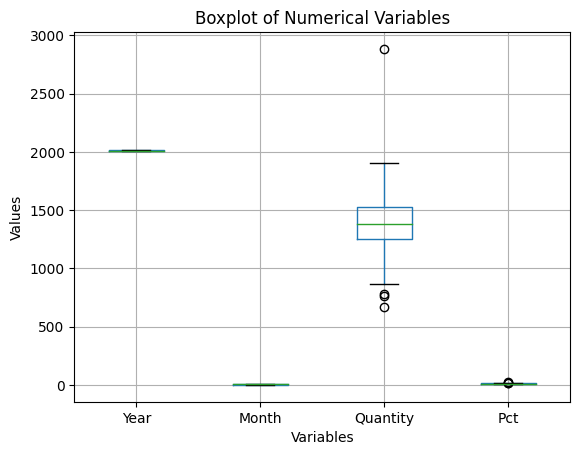

In [7]:
df.boxplot()

plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()

In [8]:
#combine year and month column, and convert the year_month column to datetime format
df['year_month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df.drop(['Year', 'Month'], axis=1, inplace=True)

In [9]:
# Sort the DataFrame by the "year_month" column to ensure that the timestamps are in ascending order.
df = df.sort_values(by='year_month')
# Calculate the time differences between consecutive timestamps
time_diffs = df['year_month'].diff()
print("Time interval:", time_diffs.min())
df.set_index('year_month', inplace=True)
df

Time interval: 28 days 00:00:00


,Make,Quantity,Pct
year_month,,,
2007-01-01,Toyota,2884,22.7
2007-02-01,Toyota,1885,19.2
2007-03-01,Toyota,1833,16.3
2007-04-01,Toyota,1300,14.7
2007-05-01,Toyota,1866,15.5
...,...,...,...
2016-08-01,Toyota,1824,13.8
2016-09-01,Toyota,1823,13.2
2016-10-01,Toyota,1327,11.1


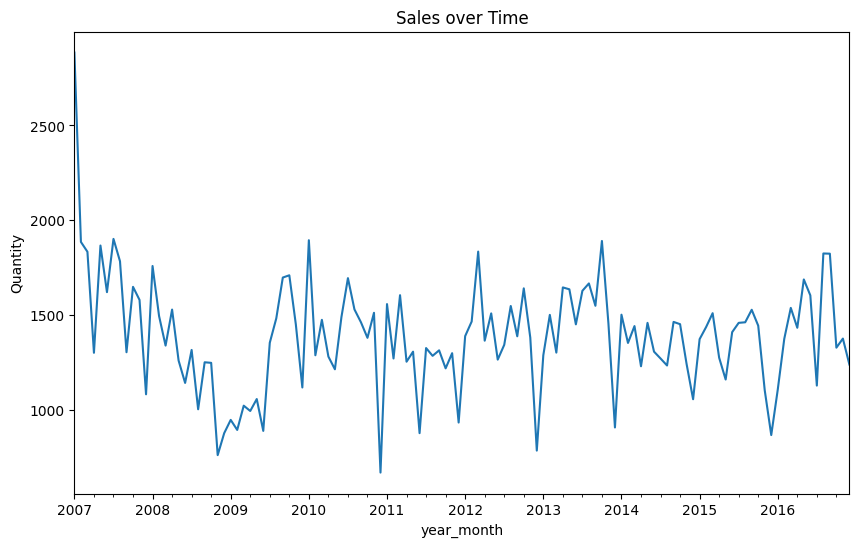

In [10]:
# Visualize the original series data
df['Quantity'].plot(kind='line', figsize=(10, 6))
plt.title('Sales over Time')
plt.xlabel('year_month')
plt.ylabel('Quantity')
plt.show()

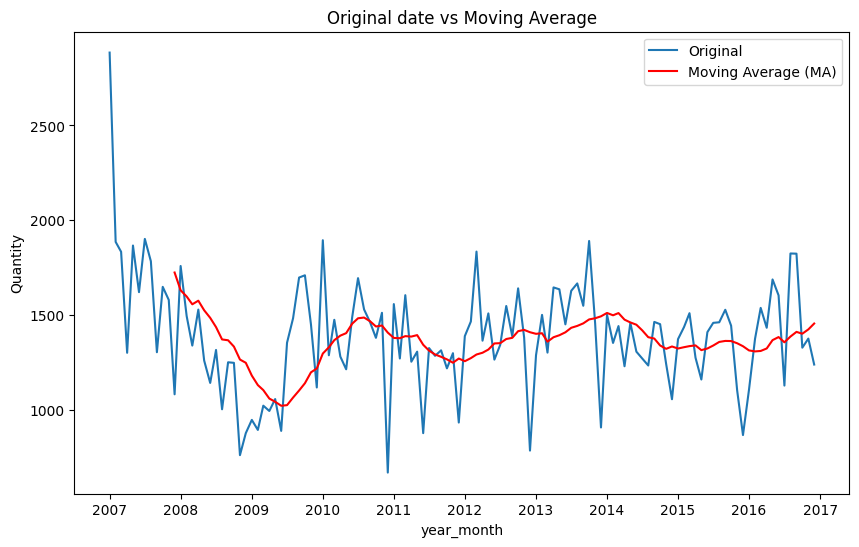

In [11]:
# Define the window size for the moving average
window_size =12

# Calculate the moving average
moving_avg = df['Quantity'].rolling(window=window_size).mean()

# Plot the original data and the moving average
plt.figure(figsize=(10, 6))
plt.plot(df['Quantity'], label='Original')
plt.plot(moving_avg, color='red', label='Moving Average (MA)')
plt.xlabel('year_month')
plt.ylabel('Quantity')
plt.title('Original date vs Moving Average')
plt.legend()
plt.show()

In [12]:
#calculates an exponential moving average (EMA) for the original time series  with a 12 Months window.
ema_window = 12  # 12 Months moving average
ema = df['Quantity'].ewm(span=ema_window, adjust=False).mean()
ema

year_month
2007-01-01    2884.000000
2007-02-01    2730.307692
2007-03-01    2592.260355
2007-04-01    2393.451070
2007-05-01    2312.304751
                 ...     
2016-08-01    1443.642249
2016-09-01    1502.004980
2016-10-01    1475.081137
2016-11-01    1459.684039
2016-12-01    1425.578802
Name: Quantity, Length: 120, dtype: float64

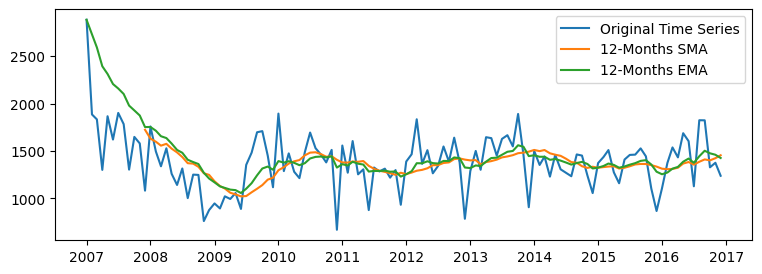

In [13]:
plt.figure(figsize=(9,3))
plt.plot(df['Quantity'], label='Original Time Series')
plt.plot(moving_avg , label=f'{ema_window}-Months SMA')
plt.plot(ema, label=f'{ema_window}-Months EMA')
plt.legend()

In [14]:
# Check stationarity using Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    # Interpret results
    if dftest[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis (H0)")
        print("Interpretation: The data is likely stationary")
    else:
        print("Conclusion: Fail to reject the null hypothesis (H0)")
        print("Interpretation: The data is likely non-stationary")

# Apply the function to the time series data
adf_test(df['Quantity'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.204220
p-value                          0.019742
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Conclusion: Reject the null hypothesis (H0)
Interpretation: The data is likely stationary


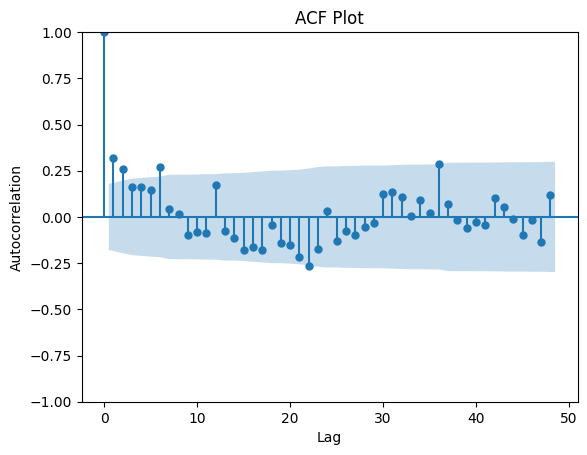

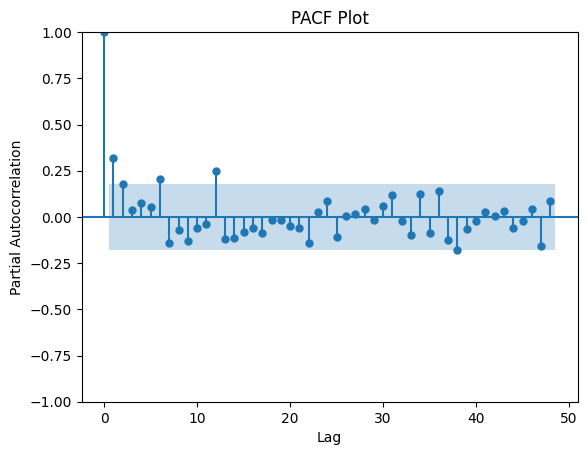

In [15]:
# Plot ACF
plot_acf(df['Quantity'], lags=48)
plt.title('ACF Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plot_pacf(df['Quantity'], lags=48)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

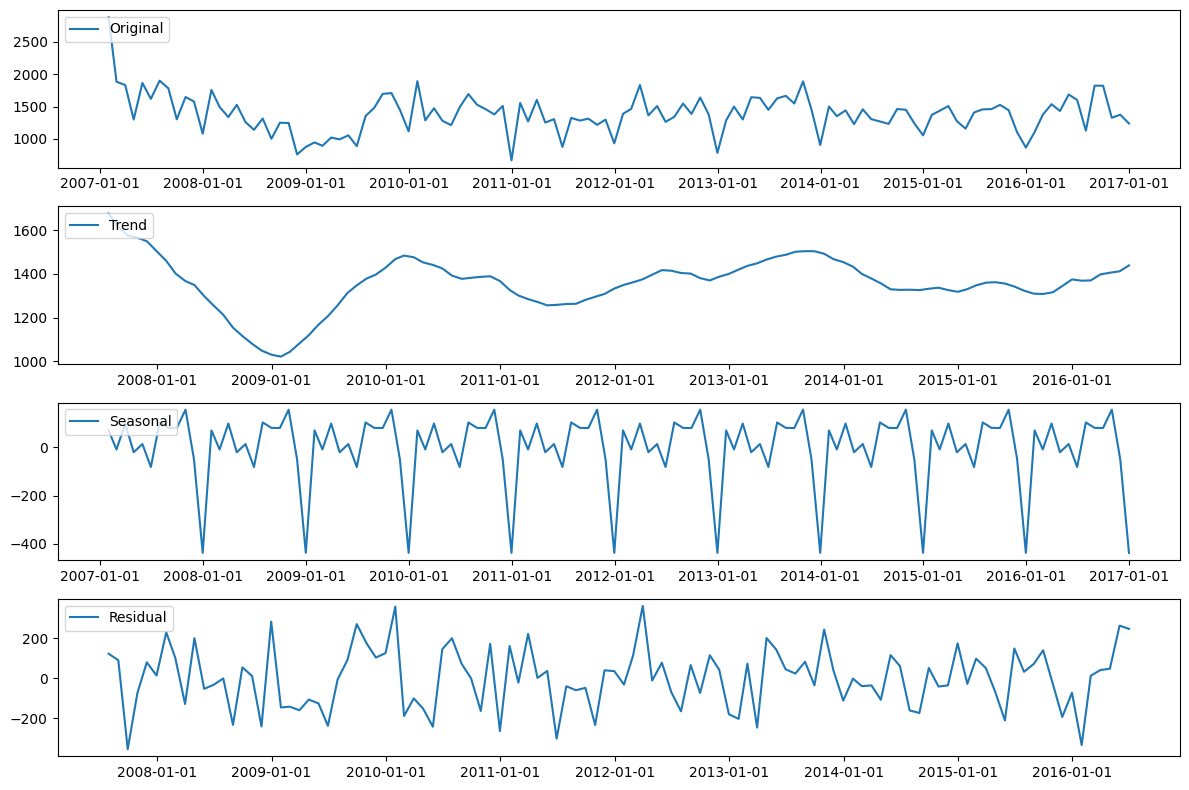

In [16]:
# Set the start date explicitly
start_date = '2007-01-01'
df.index = pd.date_range(start=start_date, periods=len(df), freq='M')

# Perform seasonal decomposition, exhibit seasonal patterns on a yearly basis
result = seasonal_decompose(df['Quantity'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df.index, df['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.subplot(412)
plt.plot(df.index, result.trend, label='Trend')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.subplot(413)
plt.plot(df.index, result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.subplot(414)
plt.plot(df.index, result.resid, label='Residual')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


In [17]:
# Split data into train and test sets
train_data = df['Quantity'][:-12]
test_data = df['Quantity'][-12:]

In [18]:
# Fit SARIMA model on training data using auto_arima
model = auto_arima(train_data, seasonal=True, m=12)
print(model.summary())

# Forecast the next 12 months
forecast = model.predict(n_periods=12)

mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood                -750.601
Date:                              Thu, 13 Jun 2024   AIC                           1513.203
Time:                                      00:36:51   BIC                           1529.295
Sample:                                  01-31-2007   HQIC                          1519.728
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    629.1242    256.571      2.452      0.014     126.255    1131.994
ar.L1          0.55

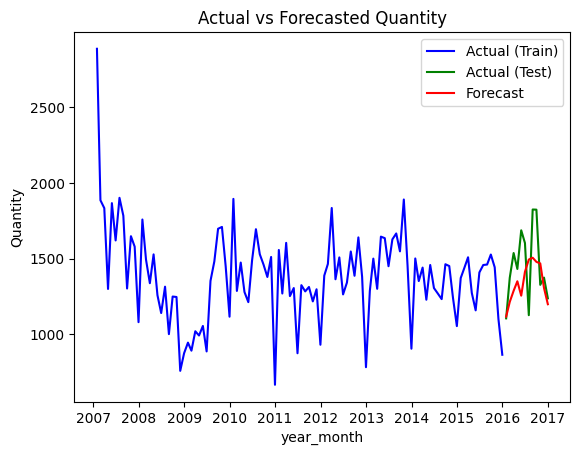

In [19]:
# Plot actual values
plt.plot(df.index[:-12], train_data, label='Actual (Train)', color='blue')
plt.plot(df.index[-12:], test_data, label='Actual (Test)', color='green')

# Plot forecasted values
plt.plot(df.index[-12:], forecast, label='Forecast', color='red')

# Add labels and title
plt.xlabel('year_month')
plt.ylabel('Quantity')
plt.title('Actual vs Forecasted Quantity')
plt.legend()

# Show plot
plt.show()

In [20]:
train_exog = df[['Pct']][:-12]  # Exogenous variables for training set
test_exog = df[['Pct']][-12:]   # Exogenous variables for test set

In [21]:
# Fit SARIMAX model with exogenous variables using auto_arima
model_exog = auto_arima(train_data, exogenous=train_exog, seasonal=True, m=12,
                   start_p=1, d=None, start_q=1,
                   max_p=3, max_d=2, max_q=3,
                   start_P=1, D=None, start_Q=1,
                   max_P=3, max_D=1, max_Q=3,
                   max_order=None, trace=True, error_action='ignore', suppress_warnings=True)

forecast = model_exog.predict(n_periods=12, exogenous=test_exog)

# Evaluate the forecast
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1544.410, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1529.913, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1530.080, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1875.428, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1530.963, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1531.434, Time=3.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1521.351, Time=1.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1519.830, Time=1.17 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1523.684, Time=3.00 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1523.040, Time=4.62 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1540.992, Time=0.43 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1513.726, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1527.633, Time=0.63 sec
 ARIMA(2,0,0)(1,0,1)[12]

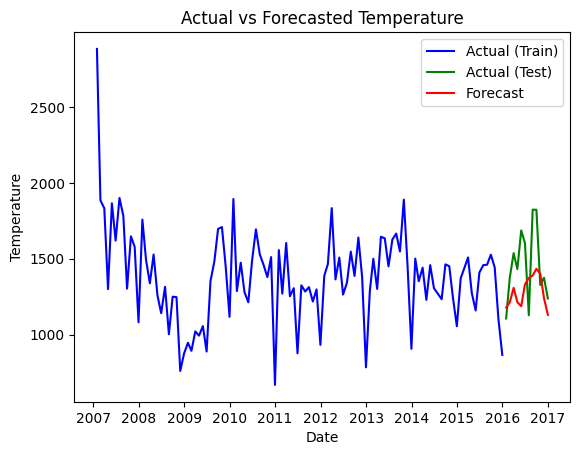

In [22]:
# Plot actual values
plt.plot(df.index[:-12], train_data, label='Actual (Train)', color='blue')
plt.plot(df.index[-12:], test_data, label='Actual (Test)', color='green')

# Plot forecasted values
plt.plot(df.index[-12:], forecast, label='Forecast', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Forecasted Temperature')
plt.legend()

# Show plot
plt.show()

In [23]:
print(model_exog.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -748.447
Date:                            Thu, 13 Jun 2024   AIC                           1506.894
Time:                                    00:37:20   BIC                           1520.304
Sample:                                01-31-2007   HQIC                          1512.331
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    190.9402     71.816      2.659      0.008      50.184     331.696
ar.L1          0.3632      0.088   